# Importing Modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline

plt.ion()   # interactive mode

## Checking hardware and cuda support

In [2]:
torch.cuda.empty_cache()
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
cuda0 = torch.device('cuda:0')
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))

1
GeForce GTX 1060 6GB
Torch 1.7.0 CUDA 10.1
Device: cuda:0


In [3]:
#DATA_FOLDER = "/content/drive/MyDrive/ColabNotebooks/bds/cnn/cars196/car_data/car_data"
DATA_FOLDER = "c:/car_data/"

#CSV_TRAIN = "/content/drive/MyDrive/ColabNotebooks/bds/cnn/cars196/car_data/anno_train.csv"
#CSV_TEST = "/content/drive/MyDrive/ColabNotebooks/bds/cnn/cars196/car_data/anno_test.csv"

#### k. Using a pre-trained model for feature extraction: 
Load in the pre-trained base model (for example, ResNet50V2) and pre-trained weights without the top layer. Freeze pre-trained model weights. Stack untrained classification layers (number of output neurons must be equal to the number of classes) on top of the pre-trained model. Normalize the data (see ImageNet normalization). Train and evaluate the model. Plot learning curves. Compare with the previous models. Which model performed better? Why?

##### Pretrained model is much better. ResNet is better. Because it trained on big dataset with high accuracy.


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(0.3),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
    ]),
}

In [5]:
data_dir = 'c:/car_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=16)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes


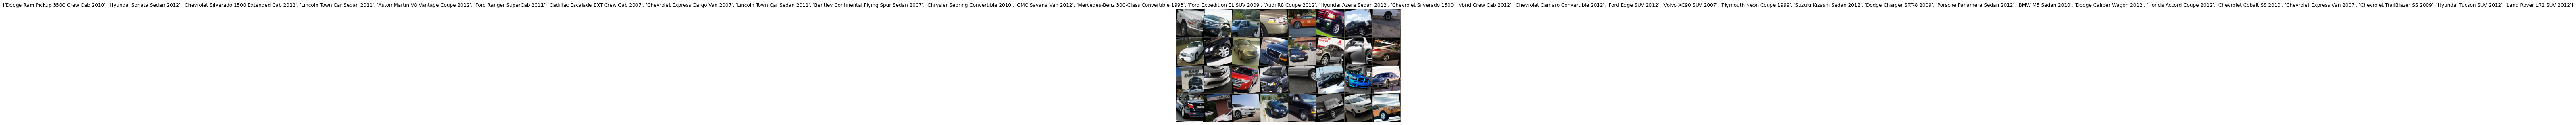

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10,10))
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_over_time_t = []
    loss_over_time_e = []
    acc_over_time_t = []
    acc_over_time_e = []
    

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(cuda0)
                labels = labels.to(cuda0)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                loss_over_time_t.append(epoch_loss)
                acc_over_time_t.append(epoch_acc.item())
            else:
                loss_over_time_e.append(epoch_loss)
                acc_over_time_e.append(epoch_acc.item())
               
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_over_time_t, acc_over_time_t, loss_over_time_e, acc_over_time_e

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(cuda0)
            labels = labels.to(cuda0)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### ResNet34 as fixed feature extractor

In [8]:
import torchvision.models as models

model_conv = models.resnet34(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 196)

model_conv = model_conv.to(cuda0)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=3, gamma=0.1)

In [9]:
model_conv, loss_conv_t, acc_conv_t, loss_conv_e, acc_conv_e  = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 5.1677 Acc: 0.0370
test Loss: 4.4791 Acc: 0.0920

Epoch 1/9
----------
train Loss: 4.3894 Acc: 0.1112
test Loss: 3.9854 Acc: 0.1526

Epoch 2/9
----------
train Loss: 3.9568 Acc: 0.1648
test Loss: 3.7029 Acc: 0.1962

Epoch 3/9
----------
train Loss: 3.4866 Acc: 0.2520
test Loss: 3.3335 Acc: 0.2587

Epoch 4/9
----------
train Loss: 3.4030 Acc: 0.2743
test Loss: 3.2855 Acc: 0.2684

Epoch 5/9
----------
train Loss: 3.3882 Acc: 0.2809
test Loss: 3.2679 Acc: 0.2733

Epoch 6/9
----------
train Loss: 3.3294 Acc: 0.2902
test Loss: 3.2773 Acc: 0.2714

Epoch 7/9
----------
train Loss: 3.3267 Acc: 0.2911
test Loss: 3.2701 Acc: 0.2707

Epoch 8/9
----------
train Loss: 3.3122 Acc: 0.3006
test Loss: 3.2324 Acc: 0.2786

Epoch 9/9
----------
train Loss: 3.3218 Acc: 0.2984
test Loss: 3.2253 Acc: 0.2783

Training complete in 11m 48s
Best val Acc: 0.278572


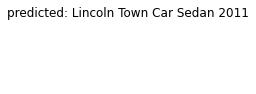

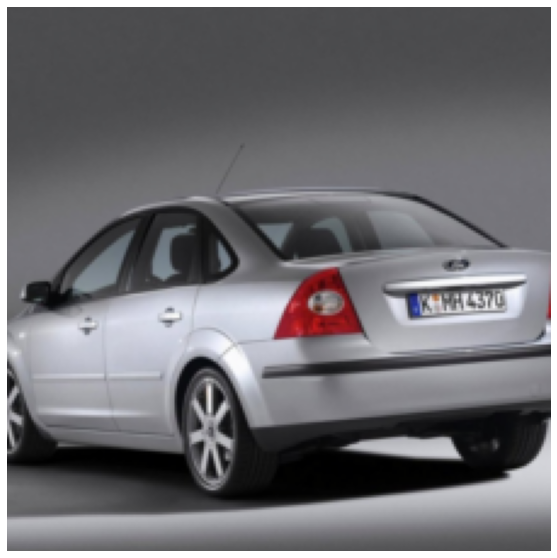

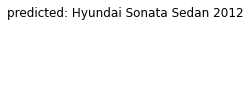

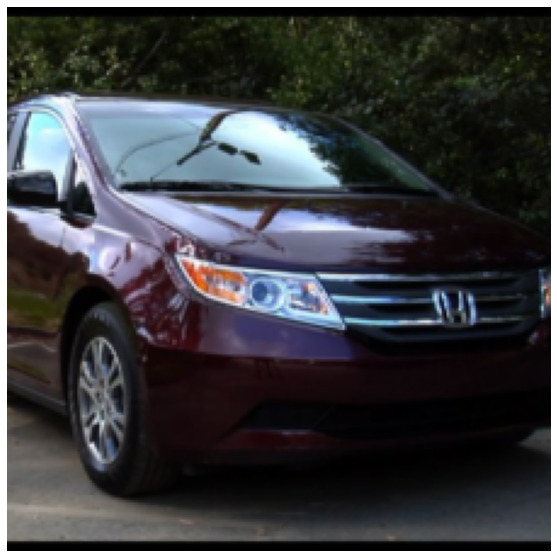

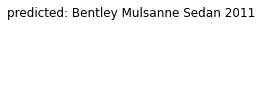

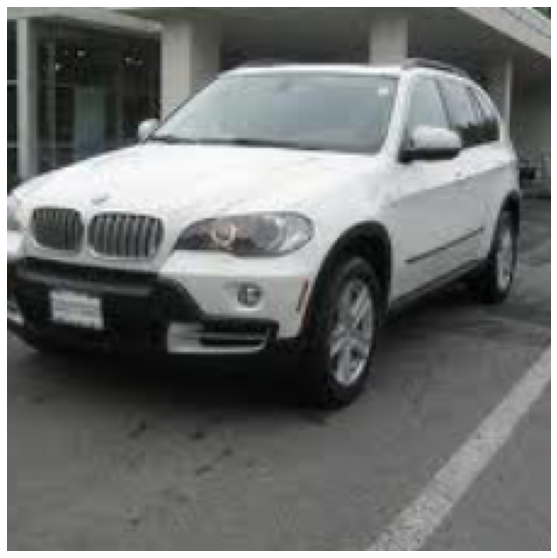

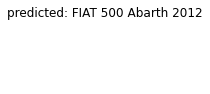

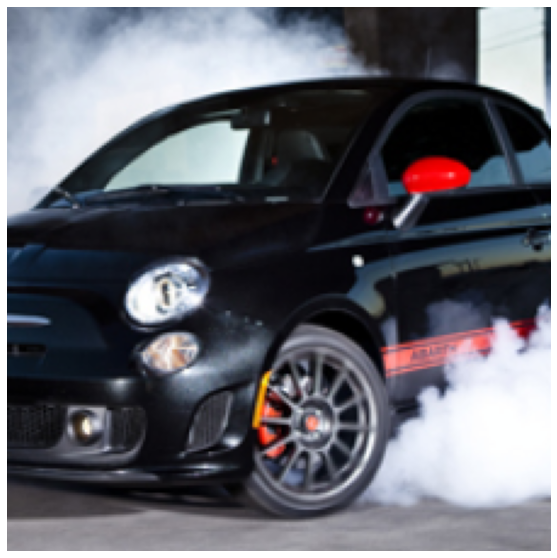

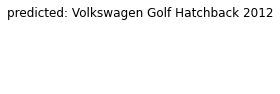

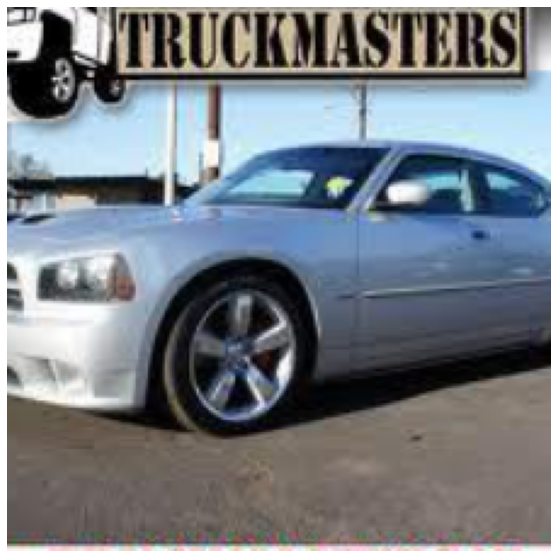

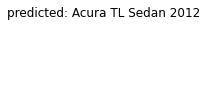

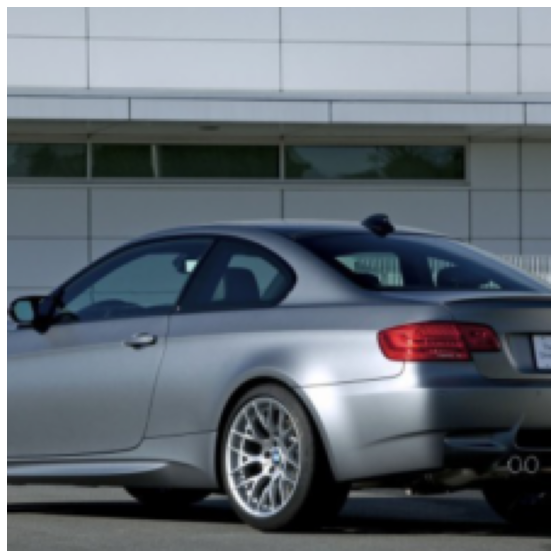

In [11]:
visualize_model(model_conv, 6)

#### l. Fine-tuning a pre-trained model:
Unfreeze weights of a couple of the top layers of the pre-trained model. Normalize the data (see ImageNet normalization). Train and evaluate the model. Plot learning curves. Compare with the previous models. Which model performed better? Why?

##### Fine tuning model is better than feature extraction, but training time is higher.

In [12]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(cuda0)
criterion_ft = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.9)

In [13]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
model_ft, loss_ft_t, acc_ft_t, loss_ft_e, acc_ft_e = train_model(model_ft,
                       criterion_ft,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=13)

Epoch 0/12
----------
train Loss: 4.9798 Acc: 0.0377
test Loss: 4.2353 Acc: 0.0960

Epoch 1/12
----------
train Loss: 3.6718 Acc: 0.1669
test Loss: 3.1933 Acc: 0.2317

Epoch 2/12
----------
train Loss: 2.8641 Acc: 0.2974
test Loss: 2.1777 Acc: 0.4299

Epoch 3/12
----------
train Loss: 2.3463 Acc: 0.4064
test Loss: 1.7222 Acc: 0.5293

Epoch 4/12
----------
train Loss: 1.9050 Acc: 0.5083
test Loss: 1.4916 Acc: 0.5774

Epoch 5/12
----------
train Loss: 1.7032 Acc: 0.5523
test Loss: 1.2491 Acc: 0.6530

Epoch 6/12
----------
train Loss: 1.5432 Acc: 0.5998
test Loss: 1.2019 Acc: 0.6573

Epoch 7/12
----------
train Loss: 1.4646 Acc: 0.6141
test Loss: 1.0951 Acc: 0.6837

Epoch 8/12
----------
train Loss: 1.2860 Acc: 0.6654
test Loss: 1.0212 Acc: 0.7095

Epoch 9/12
----------
train Loss: 1.1781 Acc: 0.6935
test Loss: 0.9267 Acc: 0.7315

Epoch 10/12
----------
train Loss: 1.1182 Acc: 0.7009
test Loss: 0.8775 Acc: 0.7472

Epoch 11/12
----------
train Loss: 1.0658 Acc: 0.7176
test Loss: 0.9203 Acc

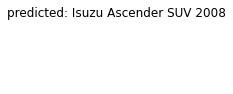

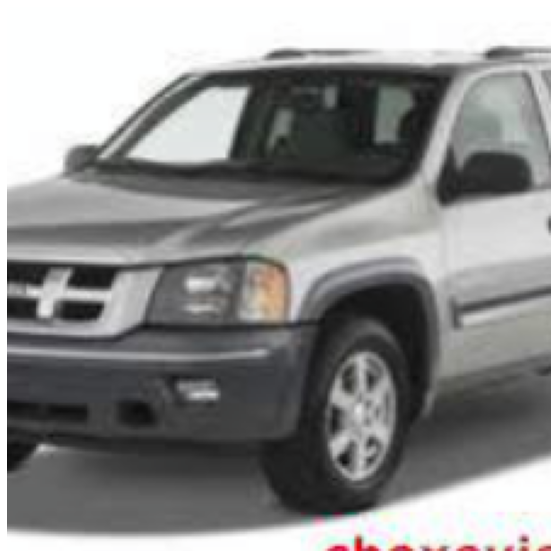

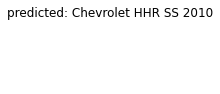

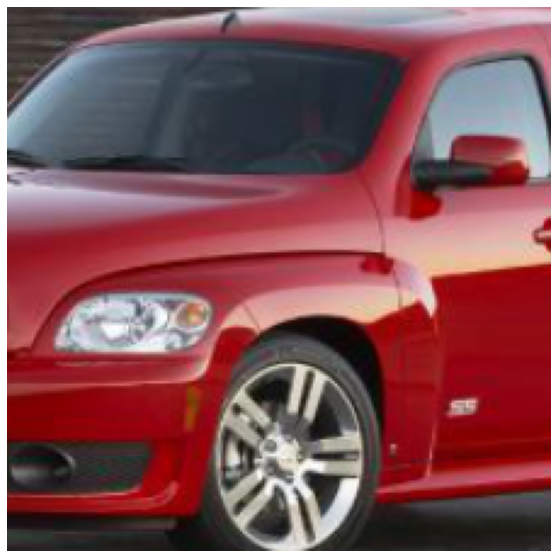

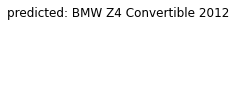

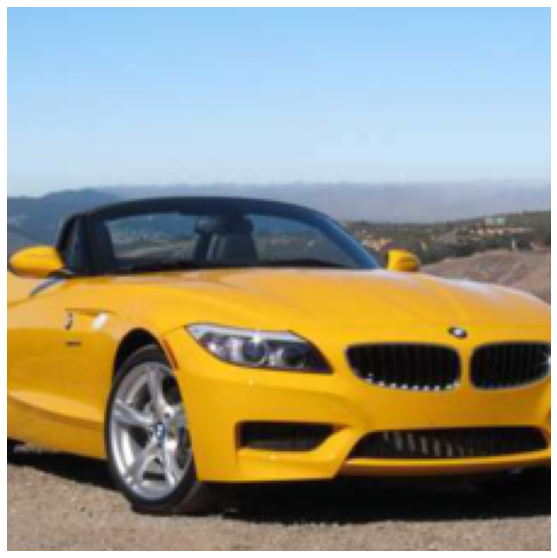

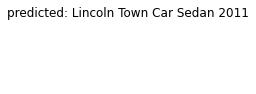

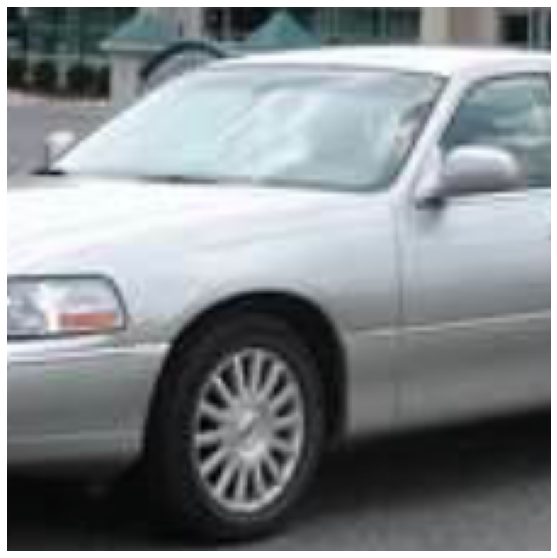

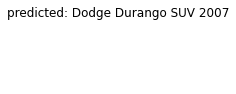

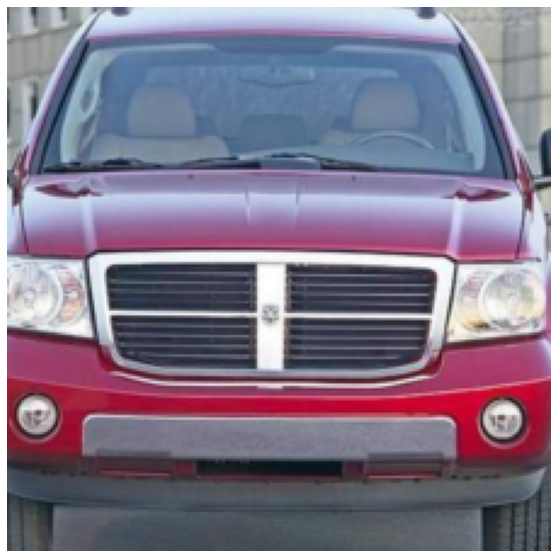

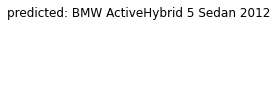

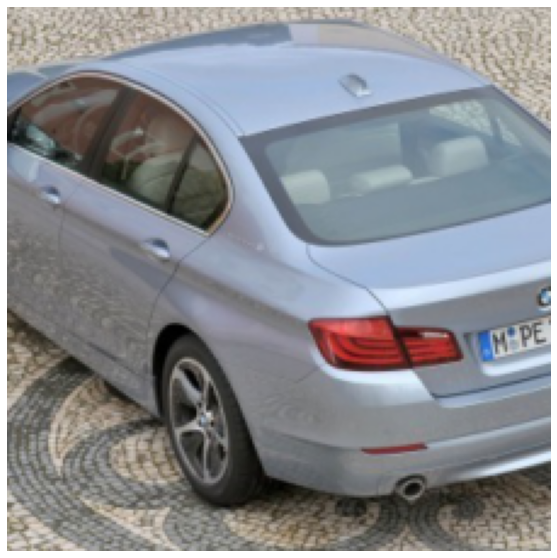

In [15]:
visualize_model(model_ft, 6)

In [14]:
torch.save(model_ft, DATA_FOLDER+'models/model_ft.pth')
torch.save(model_conv, DATA_FOLDER+'models/model_conv.pth')

In [17]:
# loading models
'''
model_ft = torch.load(DATA_FOLDER+'models/model_ft.pth')
model_ft.eval()
model_conv = torch.load(DATA_FOLDER+'models/model_conv.pth')
model_conv.eval()
'''

"\nmodel_ft = torch.load(DATA_FOLDER+'models/model_ft.pth')\nmodel_ft.eval()\nmodel_conv = torch.load(DATA_FOLDER+'models/model_conv.pth')\nmodel_conv.eval()\n"

In [19]:
# dictionary of lists  
dict_pretrain_conv = {
                'model_conv_loss_train': loss_conv_t,
                'model_conv_loss_test': loss_conv_e,
                'model_conv_acc_train': acc_conv_t,
                'model_conv_acc_test': acc_conv_e, 
              }  
    
pretrain_models_conv = pd.DataFrame(dict_pretrain_conv) 
pretrain_models_conv

model_conv_loss_train  model_conv_loss_test  model_conv_acc_train  \
0               5.167700              4.479080              0.036960   
1               4.389395              3.985363              0.111248   
2               3.956817              3.702909              0.164784   
3               3.486611              3.333548              0.251965   
4               3.403007              3.285509              0.274312   
5               3.388183              3.267911              0.280943   
6               3.329392              3.277313              0.290152   
7               3.326684              3.270106              0.291135   
8               3.312194              3.232427              0.300589   
9               3.321816              3.225337              0.298379   

   model_conv_acc_test  
0             0.092028  
1             0.152593  
2             0.196244  
3             0.258674  
4             0.268375  
5             0.273349  
6             0.271359  
7             0.270737  
8             0.278572  
9             0.278324

In [16]:
# dictionary of lists  
dict_pretrain = {
                'model_ft_loss_train': loss_ft_t,
                'model_ft_loss_test': loss_ft_e,
                'model_ft_acc_train': acc_ft_t,
                'model_ft_acc_test': acc_ft_e,
              }  
    
pretrain_models_ft = pd.DataFrame(dict_pretrain) 
pretrain_models_ft

model_ft_loss_train  model_ft_loss_test  model_ft_acc_train  \
0              4.979832            4.235322            0.037696   
1              3.671824            3.193268            0.166871   
2              2.864113            2.177741            0.297397   
3              2.346294            1.722184            0.406434   
4              1.904956            1.491557            0.508350   
5              1.703196            1.249143            0.552308   
6              1.543193            1.201924            0.599828   
7              1.464586            1.095057            0.614072   
8              1.285954            1.021243            0.665398   
9              1.178097            0.926733            0.693517   
10             1.118217            0.877504            0.700884   
11             1.065819            0.920259            0.717583   
12             0.993717            0.793422            0.733178   

    model_ft_acc_test  
0            0.096008  
1            0.231688  
2            0.429922  
3            0.529287  
4            0.577416  
5            0.653028  
6            0.657257  
7            0.683746  
8            0.709489  
9            0.731501  
10           0.747171  
11           0.738465  
12           0.776396

In [17]:
pretrain_models_ft.to_csv(DATA_FOLDER+r'models/pretrain_models_ft.csv', index=False, header=True)

In [20]:
pretrain_models_conv.to_csv(DATA_FOLDER+r'models/pretrain_models_conv.csv', index=False, header=True)

In [18]:
pretrain_models_ft = pd.read_csv(DATA_FOLDER+'models/pretrain_models_ft.csv')
pretrain_models_ft

model_ft_loss_train  model_ft_loss_test  model_ft_acc_train  \
0              4.979832            4.235322            0.037696   
1              3.671824            3.193268            0.166871   
2              2.864113            2.177741            0.297397   
3              2.346294            1.722184            0.406434   
4              1.904956            1.491557            0.508350   
5              1.703196            1.249143            0.552308   
6              1.543193            1.201924            0.599828   
7              1.464586            1.095057            0.614072   
8              1.285954            1.021243            0.665398   
9              1.178097            0.926733            0.693517   
10             1.118217            0.877504            0.700884   
11             1.065819            0.920259            0.717583   
12             0.993717            0.793422            0.733178   

    model_ft_acc_test  
0            0.096008  
1            0.231688  
2            0.429922  
3            0.529287  
4            0.577416  
5            0.653028  
6            0.657257  
7            0.683746  
8            0.709489  
9            0.731501  
10           0.747171  
11           0.738465  
12           0.776396

In [21]:
pretrain_models_conv = pd.read_csv(DATA_FOLDER+'models/pretrain_models_conv.csv')
pretrain_models_conv

model_conv_loss_train  model_conv_loss_test  model_conv_acc_train  \
0               5.167700              4.479080              0.036960   
1               4.389395              3.985363              0.111248   
2               3.956817              3.702909              0.164784   
3               3.486611              3.333548              0.251965   
4               3.403007              3.285509              0.274312   
5               3.388183              3.267911              0.280943   
6               3.329392              3.277313              0.290152   
7               3.326684              3.270106              0.291135   
8               3.312194              3.232427              0.300589   
9               3.321816              3.225337              0.298379   

   model_conv_acc_test  
0             0.092028  
1             0.152593  
2             0.196244  
3             0.258674  
4             0.268375  
5             0.273349  
6             0.271359  
7             0.270737  
8             0.278572  
9             0.278324

In [32]:
loss_aug_models = pd.read_csv(DATA_FOLDER+'models/loss_aug_models.csv')

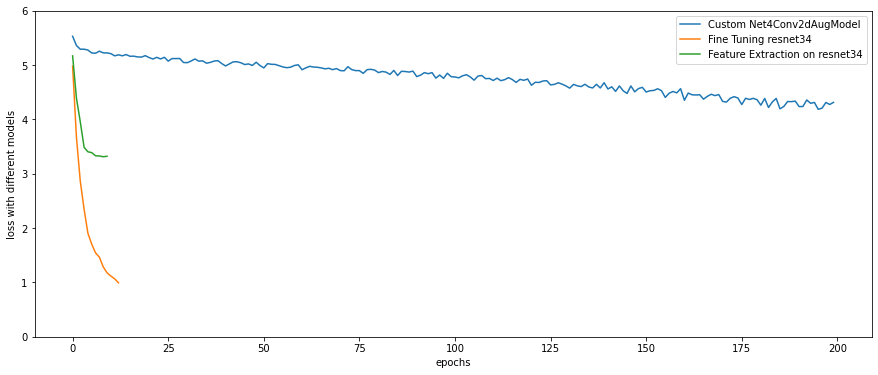

In [24]:
plt.figure(figsize=(15,6))
plt.plot(loss_aug_models['Net4Conv2dAugModel'], label = 'Custom Net4Conv2dAugModel')

plt.plot(pretrain_models_ft['model_ft_loss_train'], label = 'Fine Tuning resnet34')
plt.plot(pretrain_models_conv['model_conv_loss_train'], label = 'Feature Extraction on resnet34')

plt.xlabel('epochs')
plt.ylabel('loss with different models')
plt.ylim(0, 6) # consistent scale
plt.legend()
plt.show()

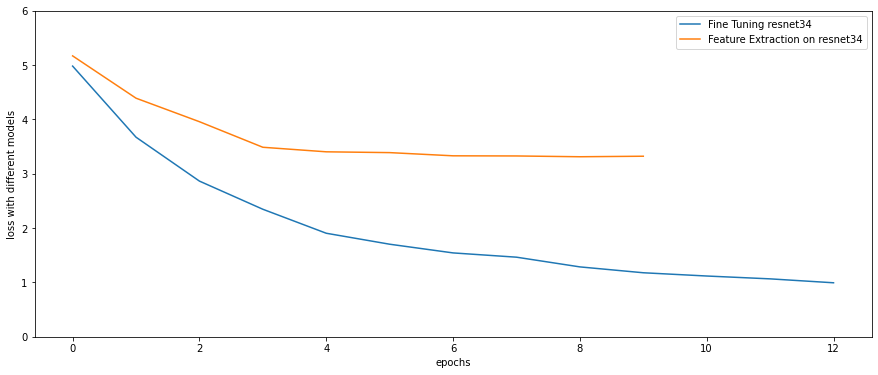

In [31]:
plt.figure(figsize=(15,6))

plt.plot(pretrain_models_ft['model_ft_loss_train'], label = 'Fine Tuning resnet34')
plt.plot(pretrain_models_conv['model_conv_loss_train'], label = 'Feature Extraction on resnet34')

plt.xlabel('epochs')
plt.ylabel('loss with different models')
plt.ylim(0, 6) # consistent scale
plt.legend()
plt.show()

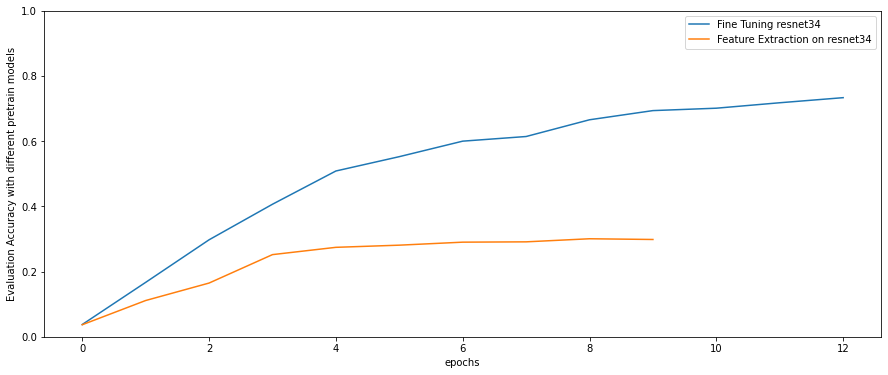

In [30]:
plt.figure(figsize=(15,6))

plt.plot(pretrain_models_ft['model_ft_acc_train'], label = 'Fine Tuning resnet34')
plt.plot(pretrain_models_conv['model_conv_acc_train'], label = 'Feature Extraction on resnet34')

plt.xlabel('epochs')
plt.ylabel('Evaluation Accuracy with different pretrain models')
plt.ylim(0, 1) # consistent scale
plt.legend()
plt.show()

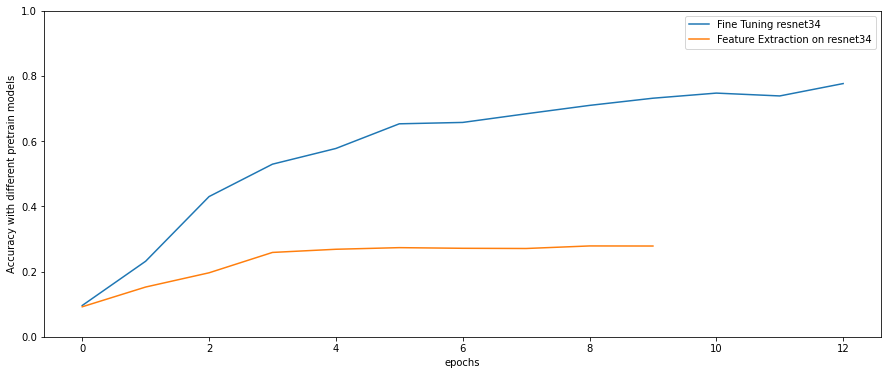

In [27]:
plt.figure(figsize=(15,6))

plt.plot(pretrain_models_ft['model_ft_acc_test'], label = 'Fine Tuning resnet34')
plt.plot(pretrain_models_conv['model_conv_acc_test'], label = 'Feature Extraction on resnet34')

plt.xlabel('epochs')
plt.ylabel('Accuracy with different pretrain models')
plt.ylim(0, 1) # consistent scale
plt.legend()
plt.show()

### Target accuracy reached!